In [1]:
import datetime

import numpy as np
import pandas as pd
import geopandas as gpd

import plotly.express as px
import plotly.graph_objects as go


import matplotlib.pyplot as plt
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

px.set_mapbox_access_token("pk.eyJ1IjoiamdhY29zdGFzIiwiYSI6ImNsYWJwd3g1ZDAwaGUzb3Q0ZG04NDNndGgifQ.brk6kVA6biVSH0ovZ1dreA")

In [20]:
columns_sex = ["DP05_0002E","DP05_0003E"]
columns_age = ["DP05_0005E","DP05_0006E","DP05_0007E","DP05_0008E","DP05_0009E","DP05_0010E","DP05_0011E","DP05_0012E","DP05_0013E","DP05_0014E","DP05_0015E","DP05_0016E","DP05_0017E"]
columns_sex_age = ["DP05_0026E","DP05_0027E", "DP05_0030E","DP05_0031E"]
columns_race = ["DP05_0037E", 'DP05_0038E', 'DP05_0039E', 'DP05_0044E', 'DP05_0052E', 'DP05_0057E']
columns_income = ['S1901_C01_012E', 'S1901_C01_013E']
columns_education = ['S1501_C01_002E', 'S1501_C01_003E', 'S1501_C01_004E', 'S1501_C01_005E', 'S1501_C01_007E', 
                     'S1501_C01_008E', 'S1501_C01_009E', 'S1501_C01_010E', 'S1501_C01_011E', 'S1501_C01_012E',
                     'S1501_C01_013E', 'S1501_C01_014E', 'S1501_C01_015E', 'S1501_C01_017E', 'S1501_C01_018E',
                     'S1501_C01_020E', 'S1501_C01_021E', 'S1501_C01_023E', 'S1501_C01_024E', 'S1501_C01_026E',
                     'S1501_C01_027E', 'S1501_C01_021E', 'S1501_C01_023E', 'S1501_C01_024E', 'S1501_C01_026E',]

best_columns_gb = ['DP05_0007E', 'S1501_C01_020E',
       'DP05_0015E', 'DP05_0009E', 'DP05_0014E', 'DP05_0013E',
       'DP05_0005E', 'DP05_0012E', 'S1501_C01_014E', 'DP05_0038E',
       'S1501_C01_018E', 'DP05_0044E', 'DP05_0003E', 'DP05_0010E',
       'S1501_C01_017E', 'Urban']

best_columns_rf = ['S1501_C01_007E', 'DP05_0009E', 'DP05_0038E',
       'S1501_C01_020E', 'DP05_0003E', 'DP05_0010E', 'DP05_0005E',
       'DP05_0015E', 'DP05_0044E', 'S1501_C01_009E', 'DP05_0012E',
       'S1501_C01_018E', 'S1501_C01_017E', 'Urban']


data_urls = [
    'Census_Clean_Zip5_IL_Household&Family_Married&Nonmarried_Income_2018.csv',
    'Census_Clean_Zip5_IL_Sex_Age_Ethnicity_2018.csv',
    'Census_Clean_Zip5_IL_EducationLevel_byAge_byIncome_Ethnicity_bySex.csv'
]

In [3]:
df_data = pd.read_csv('data/comed_month/comed_201801.csv')
df_data['date_time'] = pd.to_datetime(df_data.date_time)

df_data = df_data.groupby(['zip5', 'date_time']).energy.sum().reset_index()
df_data['weekday'] = df_data.date_time.dt.weekday
gdf_zc = gpd.read_file('data/geo/Chicago_ZC.geojson')
gdf_zc['GEOID20'] = gdf_zc['GEOID20'].astype(int)

gdf_data = pd.merge(gdf_zc, df_data, left_on='GEOID20', right_on='zip5')
gdf_data = gdf_data.groupby(['zip5', 'weekday']).sum().reset_index()
gdf_data['zip5'] = gdf_data['zip5'].astype(str)

for url in data_urls:
    df_acs = pd.read_csv(f'data/census/{url}')
    #dict_names = dict(zip(df_acs.columns, df_acs.loc[0].values))
    df_acs = df_acs.drop(0)
    df_acs['zip5'] = df_acs.NAME.str[6:]
    gdf_data = pd.merge(gdf_data, df_acs, on='zip5')

gdf_counties = gpd.read_file('data/geo/US_counties.json')

gdf_zc_c = gdf_zc.sjoin(gdf_counties, how='left')
city_zc = gdf_zc_c.query('NAME=="Cook"').GEOID20.astype(str).values

gdf_data['Urban'] = np.where(gdf_data.zip5.isin(city_zc), 1, 0)


C:\Users\Student\AppData\Local\Temp\ipykernel_13564\1547491658.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gdf_data = gdf_data.groupby(['zip5', 'weekday']).sum().reset_index()
d:\Juan\PhD\Projects\chicago-energy-cons\env\Lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


## Linear Regression

In [4]:
X, y = gdf_data[columns_age+columns_sex+columns_income+columns_race+columns_education], gdf_data.energy

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

reg = LinearRegression().fit(X_train, y_train)

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_train, y=reg.predict(X_train),
                    mode='markers',
                    name='Train data',
                    marker = {'color': '#A34184',
                              'size': 3}))

fig.add_trace(go.Scatter(x=y_test, y=reg.predict(X_test),
                    mode='markers',
                    name='Test data',
                    marker = {'color': '#49A1A3',
                              'size': 3}))

fig.add_trace(go.Scatter(x=[0, 1.5e6], y=[0, 1.5e6],
                    mode='lines',
                    name='Theoretical solution',
                    line=dict(color='black', 
                              width=1,
                              dash='dash')))

fig.update_layout(
    width=900,
    height=700,
    title="Linear Regression Model",
    xaxis_title="Actual energy consumption (kWh)", 
    yaxis_title="Predicted energy consumption (kWh)"
)


## Gradient Boosting

The mean squared error (MSE) on test set: 2396892693.7189
The R2 score (R2) on train set: 0.9764
The R2 score (R2) on test set: 0.9584


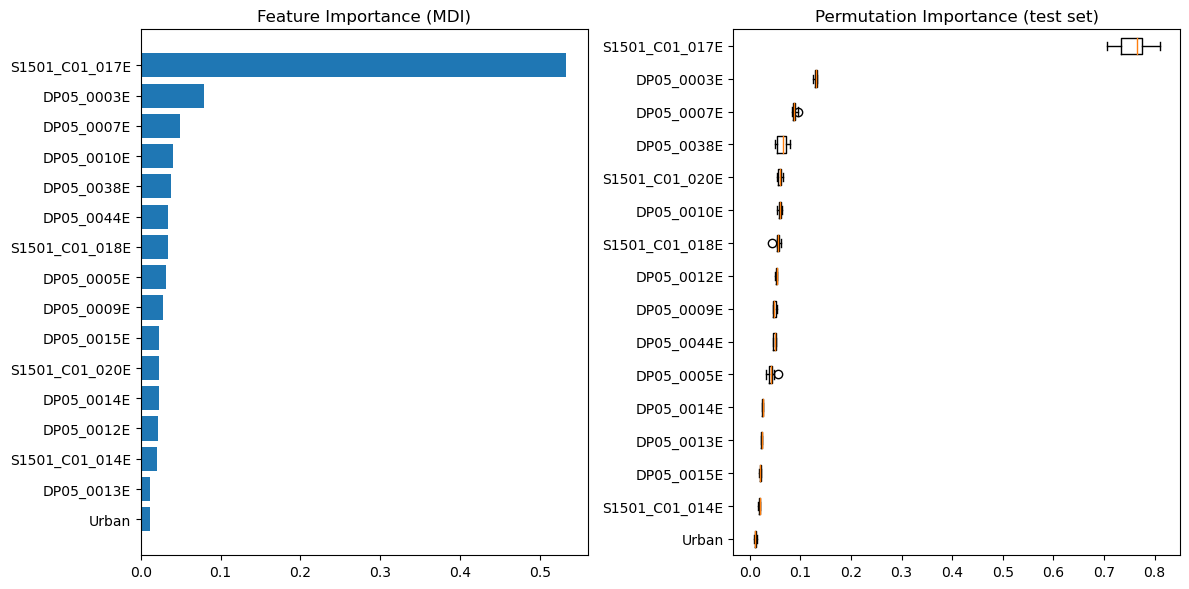

In [5]:
X, y = gdf_data[best_columns_gb], gdf_data.energy

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=13
)

params = {
    "n_estimators": 800,
    "max_depth": 6,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
r2_train = r2_score(y_train, reg.predict(X_train))
r2 = r2_score(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The R2 score (R2) on train set: {:.4f}".format(r2_train))
print("The R2 score (R2) on test set: {:.4f}".format(r2))

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_train, y=reg.predict(X_train),
                    mode='markers',
                    name='Train data',
                    marker = {'color': '#A34184',
                              'size': 3}))

fig.add_trace(go.Scatter(x=y_test, y=reg.predict(X_test),
                    mode='markers',
                    name='Test data',
                    marker = {'color': '#49A1A3',
                              'size': 3}))

fig.add_trace(go.Scatter(x=[0, 1.5e6], y=[0, 1.5e6],
                    mode='lines',
                    name='Theoretical solution',
                    line=dict(color='black', 
                              width=1,
                              dash='dash')))

fig.update_layout(
    width=900,
    height=700,
    title="Gradient Boosting Model",
    xaxis_title="Actual energy consumption (kWh)", 
    yaxis_title="Predicted energy consumption (kWh)"
)

## Random Forest Model

The mean squared error (MSE) on test set: 2242240425.0670
The R2 score (R2) on train set: 0.9703
The R2 score (R2) on test set: 0.9643


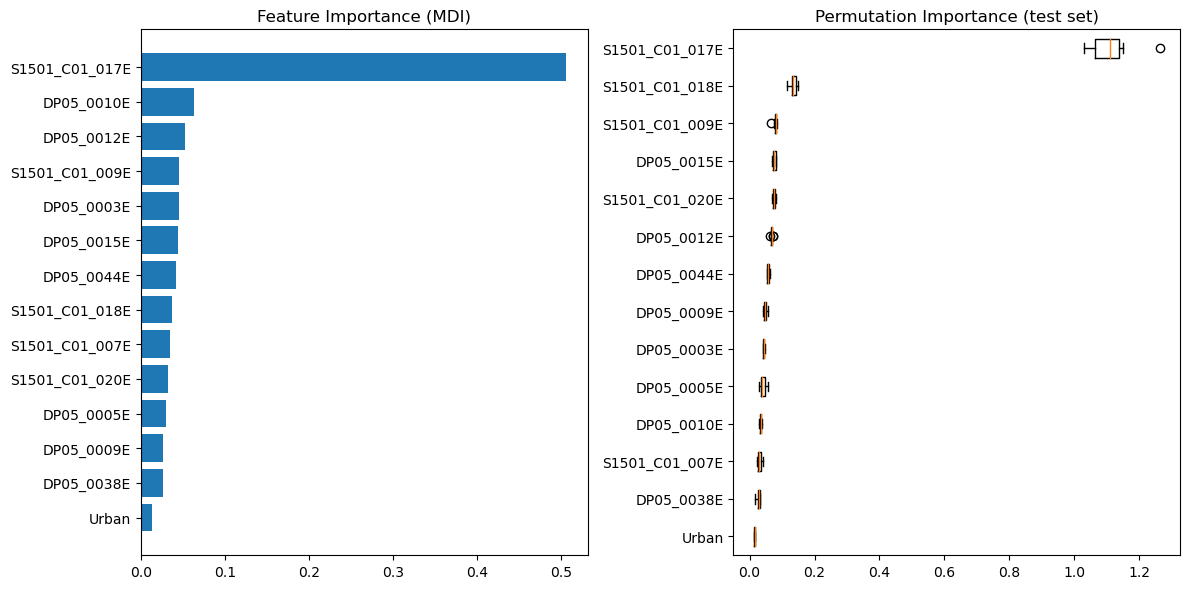

In [21]:
X, y = gdf_data[best_columns_rf], gdf_data.energy

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

reg = RandomForestRegressor(max_depth=9, random_state=0)

reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
r2_train = r2_score(y_train, reg.predict(X_train))
r2 = r2_score(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The R2 score (R2) on train set: {:.4f}".format(r2_train))
print("The R2 score (R2) on test set: {:.4f}".format(r2))

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_train, y=reg.predict(X_train),
                    mode='markers',
                    name='Train data',
                    marker = {'color': '#A34184',
                              'size': 3}))

fig.add_trace(go.Scatter(x=y_test, y=reg.predict(X_test),
                    mode='markers',
                    name='Test data',
                    marker = {'color': '#49A1A3',
                              'size': 3}))

fig.add_trace(go.Scatter(x=[0, 1.5e6], y=[0, 1.5e6],
                    mode='lines',
                    name='Theoretical solution',
                    line=dict(color='black', 
                              width=1,
                              dash='dash')))

fig.update_layout(
    width=900,
    height=700,
    title="Random Forest Model",
    xaxis_title="Actual energy consumption (kWh)", 
    yaxis_title="Predicted energy consumption (kWh)"
)



## Suppport Vector Machine Model

In [24]:
X, y = gdf_data[columns_age+columns_income+columns_education], gdf_data.energy

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=13
)

reg = SVR(C=1.0, epsilon=0.2, kernel='linear')
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
r2_train = r2_score(y_train, reg.predict(X_train))
r2 = r2_score(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The R2 score (R2) on train set: {:.4f}".format(r2_train))
print("The R2 score (R2) on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 22739608941.6943
The R2 score (R2) on train set: 0.6234
The R2 score (R2) on test set: 0.6058
